# Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from google.colab import drive
import logging


# Load the dataset

In [ ]:

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path):
    """Mounts Google Drive and loads the dataset."""
    logging.info("Mounting Google Drive and loading data.")
    drive.mount('/content/drive')
    df = pd.read_excel(file_path)
    return df

# Data preprocessing

In [ ]:
def preprocess_data(df):
    """Handles missing values and prepares the dataset for modeling."""
    logging.info("Preprocessing data: Handling missing values and cleaning the dataset.")
    df.replace(-99999, np.nan, inplace=True)

    missing_percentage = (df.isnull().sum() / len(df)) * 100
    columns_to_drop = missing_percentage[missing_percentage > 70].index
    df_cleaned = df.drop(columns=columns_to_drop)

    numeric_columns = df_cleaned.select_dtypes(include=np.number).columns
    df_cleaned[numeric_columns] = df_cleaned[numeric_columns].fillna(df_cleaned[numeric_columns].median())

    return df_cleaned


# Correlation matrix

In [ ]:
def plot_correlation_matrix(df):
    """Plots the correlation matrix for numerical features."""
    logging.info("Plotting correlation matrix.")
    plt.figure(figsize=(30, 22))
    numerical_df = df.select_dtypes(include=np.number)
    corr_matrix = numerical_df.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, mask=mask)
    plt.title("Correlation Matrix of Features", fontsize=20)
    plt.show()


# Data preparation

In [ ]:
def prepare_data(df_cleaned):
    """Prepares the data for training and splits it into train/test sets."""
    logging.info("Preparing data: Splitting into training and testing sets.")
    features = df_cleaned.drop(columns=['PROSPECTID', 'Approved_Flag'])
    target = df_cleaned['Approved_Flag'].apply(lambda x: 1 if x == 'P2' else 0)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    numeric_features = features.select_dtypes(include=np.number).columns
    categorical_features = features.select_dtypes(exclude=np.number).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    return X_train, X_test, y_train, y_test, preprocessor


# Pipeline

In [ ]:
def build_pipeline(model, preprocessor):
    """Creates a machine learning pipeline with preprocessing and the given model."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

# Fine tuning

In [ ]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    """Performs hyperparameter tuning using GridSearchCV."""
    logging.info(f"Performing hyperparameter tuning for {model.__class__.__name__}.")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    logging.info(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Training and evaluation

In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """Trains and evaluates models with cross-validation and returns the results."""
    logging.info("Training and evaluating models.")
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Neural Network": MLPClassifier(max_iter=1000)
    }

    param_grids = {
        "Logistic Regression": {
            'model__C': [0.01, 0.1, 1, 10, 100]
        },
        "Decision Tree": {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 10, 20]
        },
        "Random Forest": {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 10, 20]
        },
        "Neural Network": {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'model__alpha': [0.0001, 0.001, 0.01]
        }
    }

    results = {}
    confusion_matrices = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        pipeline = build_pipeline(model, preprocessor)
        best_pipeline = hyperparameter_tuning(pipeline, param_grids[model_name], X_train, y_train)

        cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
        mean_cv_score = np.mean(cv_scores)

        best_pipeline.fit(X_train, y_train)
        y_pred_prob = best_pipeline.predict_proba(X_test)[:, 1]
        y_pred = best_pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        pr_auc = auc(recall, precision)

        results[model_name] = {
            "Accuracy": accuracy,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Cross-Validation Accuracy": mean_cv_score
        }

        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[model_name] = cm

        # Confusion Matrix Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results, confusion_matrices


# Feature importance

In [ ]:
def plot_feature_importance(preprocessor, model):
    """Plots the top 10 most important features for the given model."""
    logging.info("Plotting feature importance.")
    feature_importances = model.feature_importances_
    feature_names = preprocessor.get_feature_names_out()

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    top_features = feature_importance_df.head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Main function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


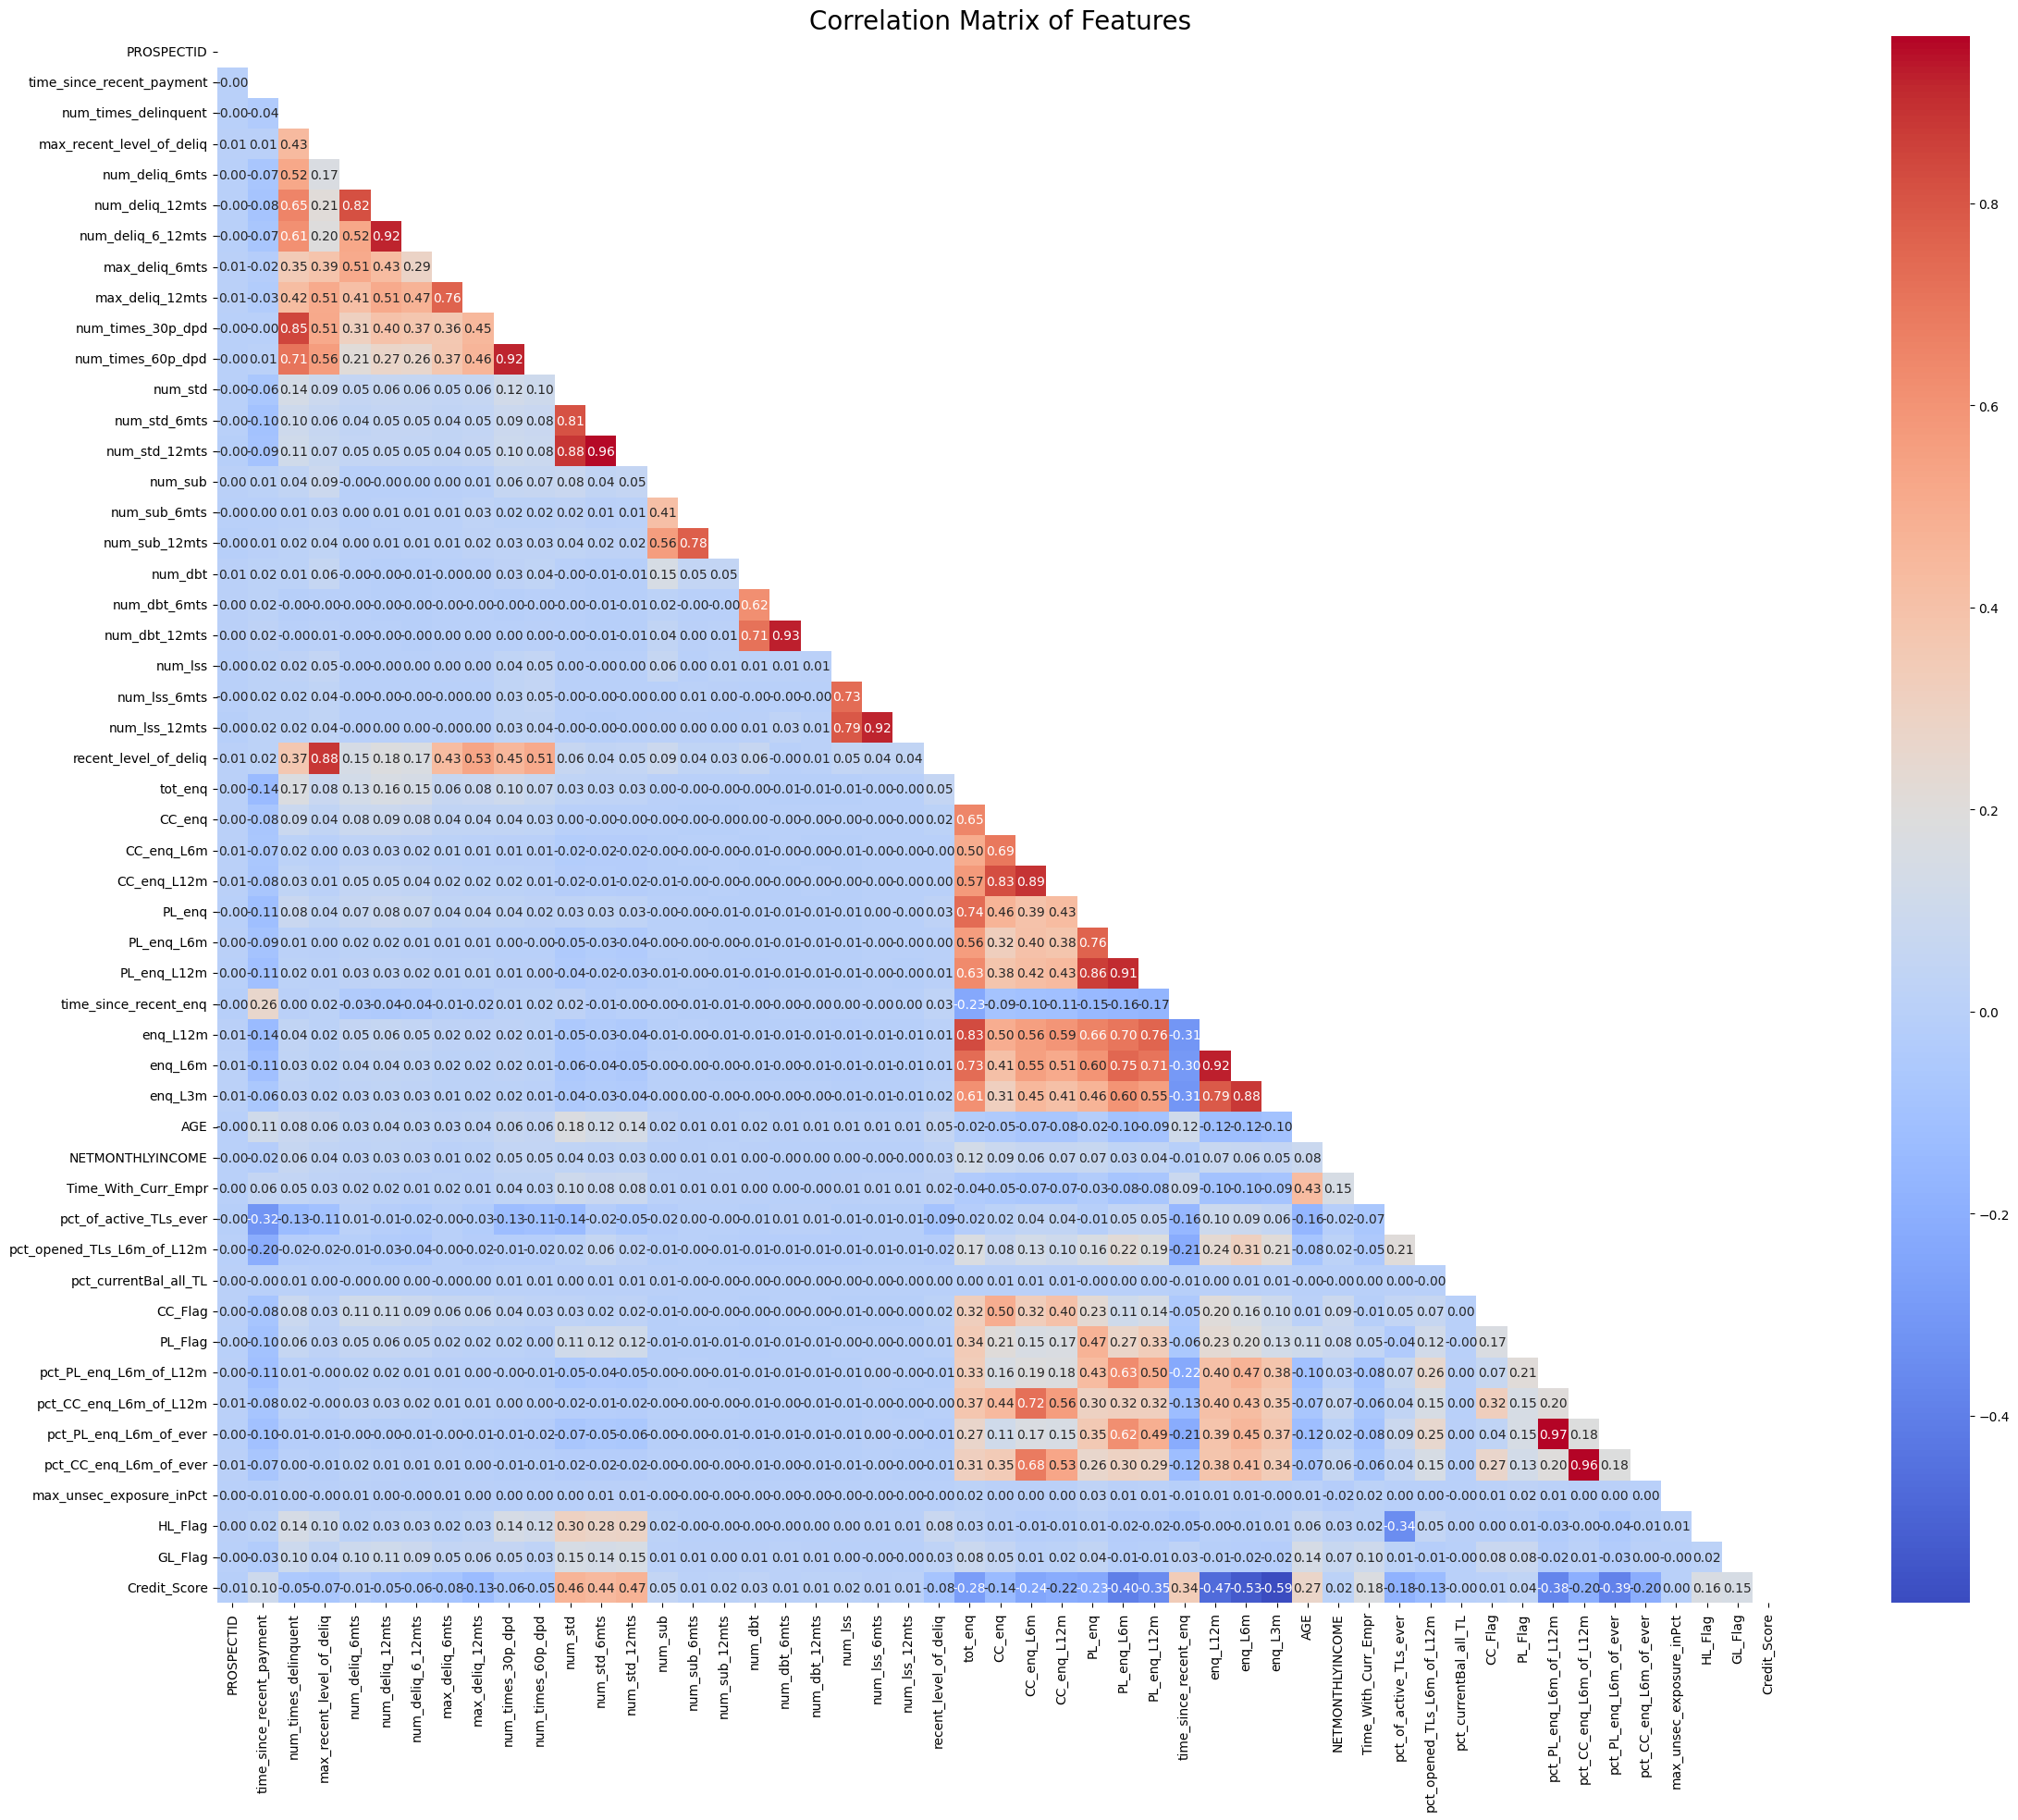

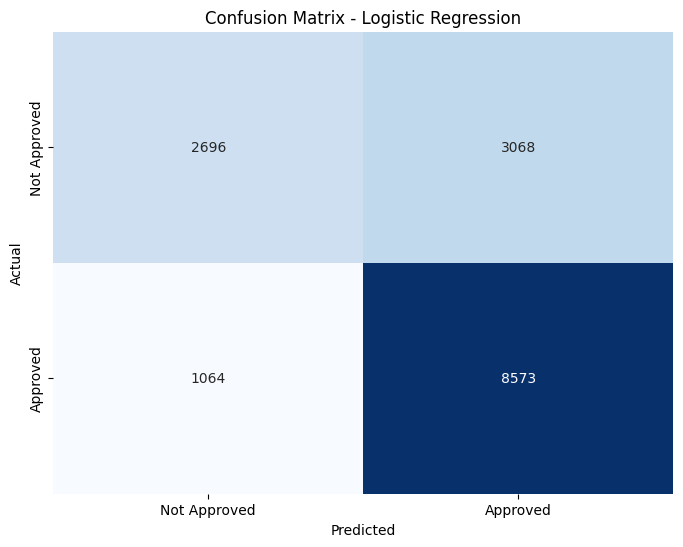

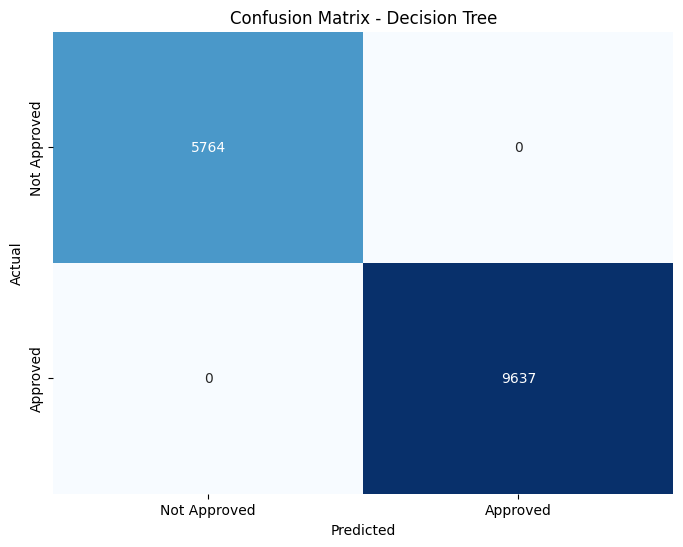

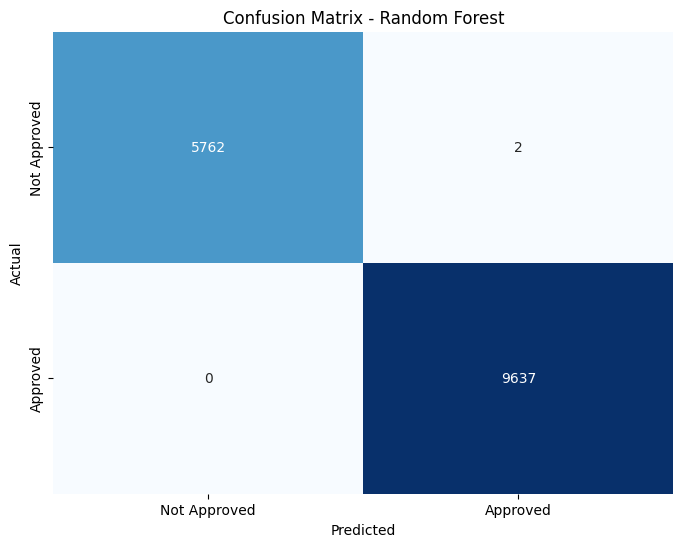

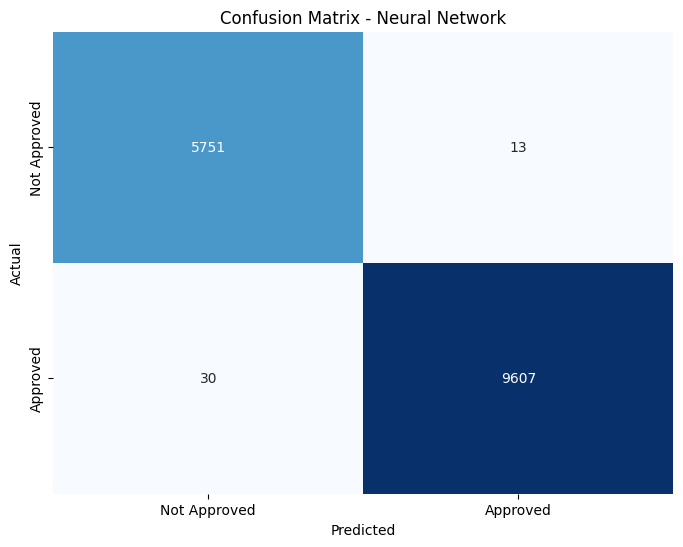

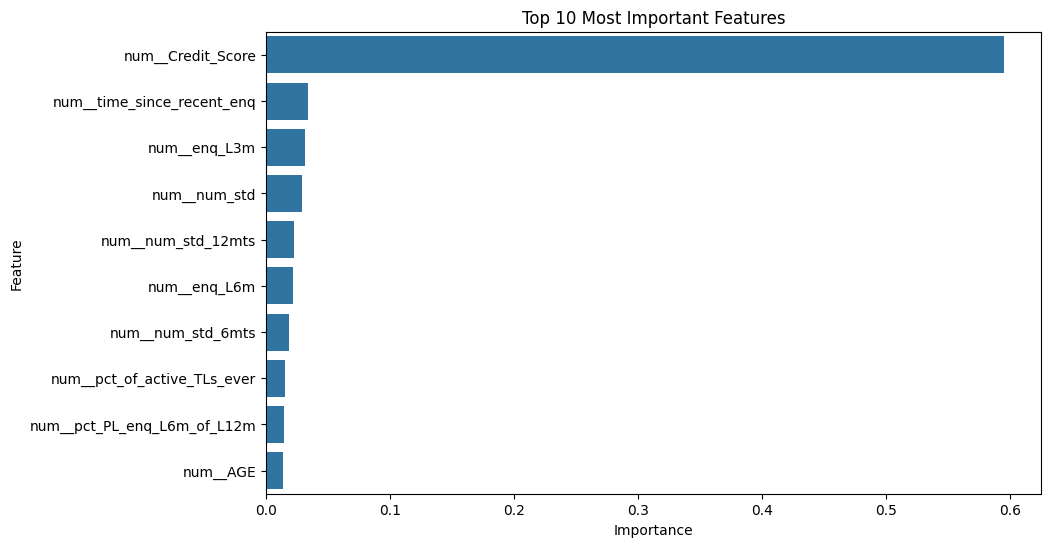

                     Accuracy   ROC-AUC    PR-AUC  Cross-Validation Accuracy
Logistic Regression  0.731706  0.777408  0.827705                   0.737498
Decision Tree        1.000000  1.000000  1.000000                   1.000000
Random Forest        0.999870  1.000000  1.000000                   0.999443
Neural Network       0.997208  0.999754  0.999192                   0.997050


In [ ]:
# Main function to run all steps
def main():
    file_path = '/content/drive/MyDrive/External_Cibil_Dataset.xlsx'
    df = load_data(file_path)
    df_cleaned = preprocess_data(df)
    plot_correlation_matrix(df_cleaned)

    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df_cleaned)
    results, confusion_matrices = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

    # Use the pipeline for fitting the Random Forest model
    rf_pipeline = build_pipeline(RandomForestClassifier(), preprocessor)
    rf_pipeline.fit(X_train, y_train)  # Fit the pipeline, not just the model
    plot_feature_importance(preprocessor, rf_pipeline.named_steps['model']) # Access the model from the pipeline

    # Print results
    logging.info("Final evaluation results:")
    print(pd.DataFrame(results).T)

if __name__ == "__main__":
    main()